In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient
from glob import glob
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

2023-01-30 17:42:02.791826: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-30 17:42:02.791947: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
GCS_DS_PATH = KaggleDatasets().get_gcs_path('website-defacement')

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
N_JOBS = cpu_count()

IMG_SIZE = 224
EPOCHS = 50

print('N_JOBS:', N_JOBS)
print('Batch size:', BATCH_SIZE)
print('GCS_DS_PATH:', GCS_DS_PATH)

Running on TPU: grpc://10.0.0.2:8470


2023-01-30 17:42:08.249612: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-30 17:42:08.251602: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-30 17:42:08.251636: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-30 17:42:08.251665: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0cc90703a311): /proc/driver/nvidia/version does not exist
2023-01-30 17:42:08.254359: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

N_JOBS: 4
Batch size: 64
GCS_DS_PATH: gs://kds-cf66edfbb3bc4d08a417f479c3e7836a0b3f494422aec4abb1e0b62f


In [3]:
dataset_path = '../input/website-defacement/dataset/'
img_paths = glob(dataset_path + 'image/*/*')
txt_paths = glob(dataset_path + 'text/*/*')
img_names = [path.split('/')[-1][:-4] for path in img_paths]
txt_names = [path.split('/')[-1][:-4] for path in txt_paths]
names = list(set(img_names).intersection(txt_names))

def prepare_data(name):
    if glob(dataset_path + f'image/defaced/{name}.png'):
        return (f'{GCS_DS_PATH}/dataset/image/defaced/{name}.png', 1)
    else:
        return (f'{GCS_DS_PATH}/dataset/image/benign/{name}.png', 0)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, 
                                                      random_state=42)

print(len(X_train), len(X_valid), len(X_test))

  0%|          | 0/96234 [00:00<?, ?it/s]

57740 19247 19247


In [4]:
def decode_image(filename, label=None):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_png(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    if label is None:
        return image
    else:
        return image, label

train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_train, y_train))
    .shuffle(100000)
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices(X_test)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

valid_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_valid, y_valid))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

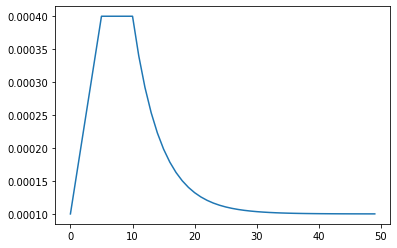

In [5]:
def lrfn(epoch=EPOCHS,
         lr_start=1e-4,
         lr_max=5e-5 * 8, 
         lr_min=1e-4,
         lr_rampup_epochs=5,
         lr_sustain_epochs=5,
         lr_exp_decay=0.8):
    if epoch < lr_rampup_epochs:
        lr = (lr_max-lr_start)/lr_rampup_epochs*epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max-lr_min)*lr_exp_decay**(epoch-lr_rampup_epochs-lr_sustain_epochs) + lr_min
    return lr

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

y = [lrfn(x) for x in range(EPOCHS)]
plt.plot(y)

In [6]:
!pip install --quiet vit-keras
from vit_keras.vit import vit_l32

with strategy.scope():
    net = vit_l32(
        image_size = (IMG_SIZE,IMG_SIZE),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False)

    model = Sequential()
    model.add(net)
    model.add(L.BatchNormalization())
    model.add(L.Dense(128, activation='softmax'))
    model.add(L.BatchNormalization())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
print(model.summary())

1226661888/1226658854 [==============================] - 62s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-l32 (Functional)         (None, 1024)              305510400 
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 305,646,466
Trainable params: 305,644,162
Non-trainable params: 2,304
_________________________________________________________________
None


In [7]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('weights.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[lrs, mc], 
                 validation_data=valid_dataset, verbose=2)

Epoch 1/50
902/902 - 2748s - loss: 0.5339 - accuracy: 0.7519 - val_loss: 0.5376 - val_accuracy: 0.7701
Epoch 2/50
902/902 - 116s - loss: 0.5255 - accuracy: 0.7618 - val_loss: 0.5024 - val_accuracy: 0.7706
Epoch 3/50
902/902 - 116s - loss: 0.5091 - accuracy: 0.7637 - val_loss: 0.5497 - val_accuracy: 0.7682
Epoch 4/50
902/902 - 116s - loss: 0.5062 - accuracy: 0.7589 - val_loss: 0.5911 - val_accuracy: 0.6936
Epoch 5/50
902/902 - 116s - loss: 0.4920 - accuracy: 0.7608 - val_loss: 0.7919 - val_accuracy: 0.6194
Epoch 6/50
902/902 - 116s - loss: 0.4855 - accuracy: 0.7640 - val_loss: 0.4513 - val_accuracy: 0.7821
Epoch 7/50
902/902 - 116s - loss: 0.4812 - accuracy: 0.7628 - val_loss: 0.4448 - val_accuracy: 0.7711
Epoch 8/50
902/902 - 116s - loss: 0.4873 - accuracy: 0.7647 - val_loss: 0.4981 - val_accuracy: 0.7717
Epoch 9/50
902/902 - 116s - loss: 0.4740 - accuracy: 0.7673 - val_loss: 0.4430 - val_accuracy: 0.7749
Epoch 10/50
902/902 - 115s - loss: 0.4616 - accuracy: 0.7672 - val_loss: 0.4767 -

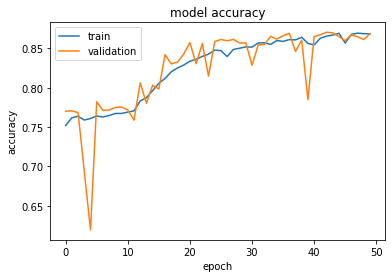

In [8]:
plot_hist(hist)

In [9]:
with strategy.scope():
    model.load_weights('weights.h5')

y_prob = model.predict(test_dataset)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.8475    0.9474    0.8946     11436
           1     0.9069    0.7504    0.8212      7811

    accuracy                         0.8674     19247
   macro avg     0.8772    0.8489    0.8579     19247
weighted avg     0.8716    0.8674    0.8648     19247

[[10834   602]
 [ 1950  5861]]
      TPR       FPR       FNR   ROC AUC
   0.7504    0.0526    0.2496    0.9393
